<a href="https://colab.research.google.com/github/YoshifumiMiyagi/VinDr-PCXR/blob/main/VinDr_PCXR_keras_vol_3_(segmentation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
# import zipfile
# with zipfile.ZipFile("/content/drive/MyDrive/download.zip", 'r') as zip_ref:
#     zip_ref.extractall("/content")

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import os
import cv2
import tensorflow as tf
from keras import backend as K
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.models import load_model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D, Flatten,Input
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.utils import to_categorical

In [29]:
# df = np.load("/content/drive/MyDrive/VinDR_PCXR_224_224_label_case2157_control5143.npy")

In [30]:
df = np.load("/content/drive/MyDrive/my_array.npz")['arr_0'] # segmentation_data

In [31]:
df.shape

(7300, 50177)

In [32]:
images, labels = 255-df[:,:-1], df[:,-1]
pd.Series(labels).value_counts()

,count
0.0,5143
1.0,2157


In [33]:
Case = images[labels==1]
Control = images[labels==0]

In [34]:
size = 224

# Case

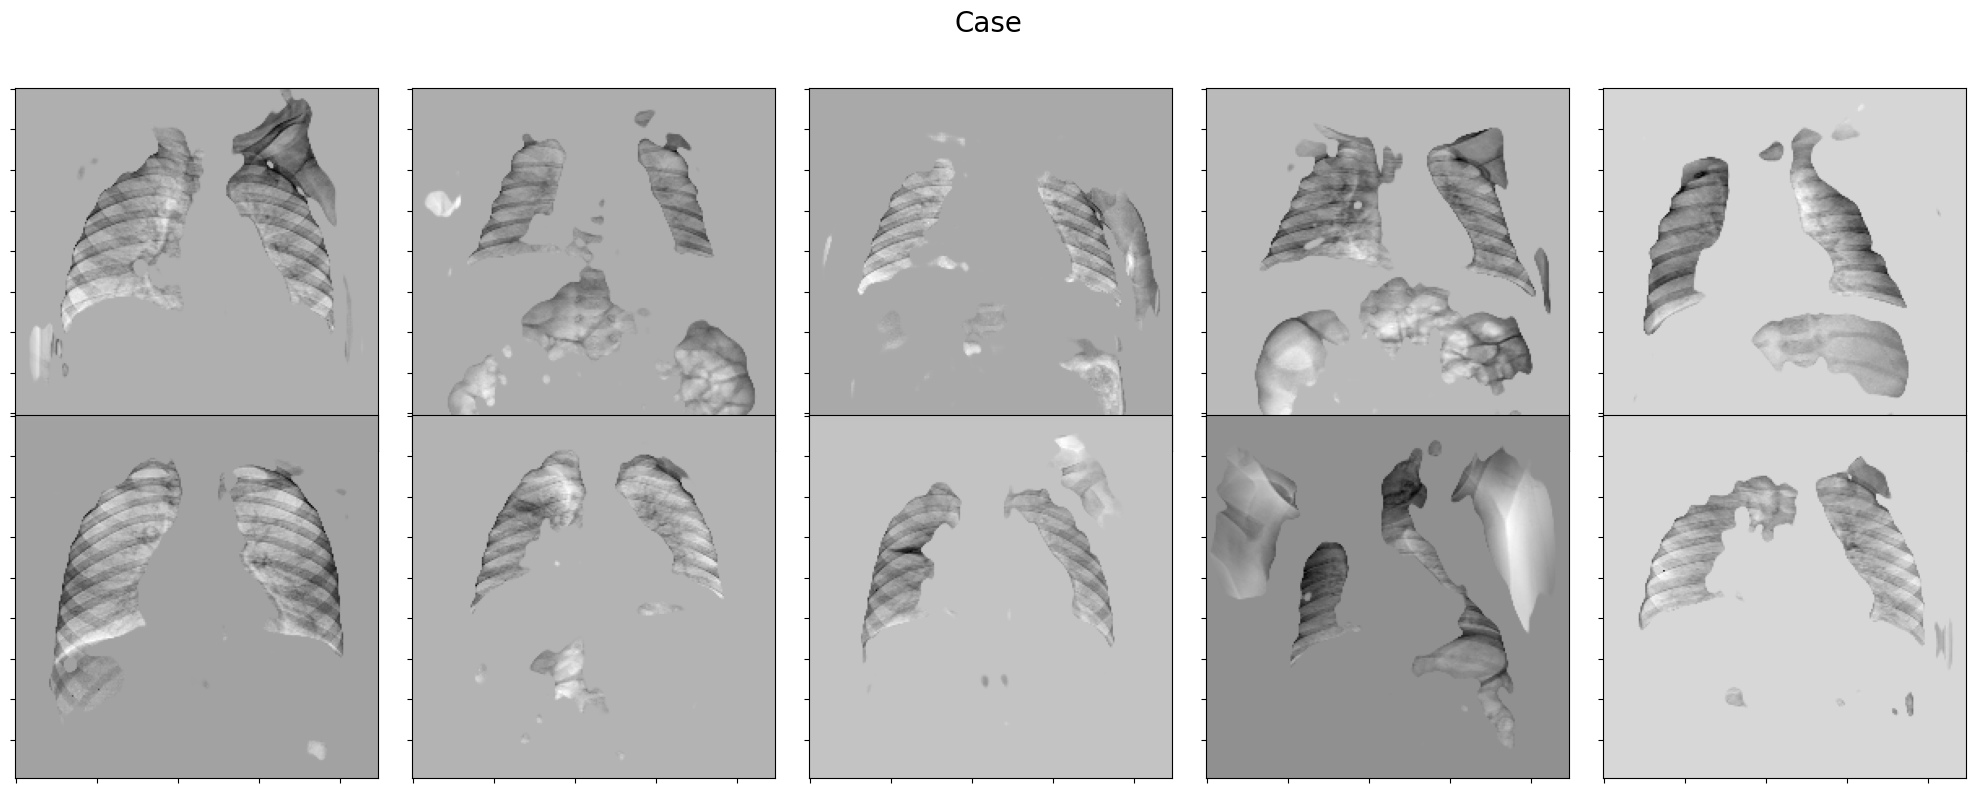

In [35]:
f = plt.figure(figsize=(20,8))
f.subplots_adjust(top=1)
num_images = Case.shape[0]
for i in range(10):
    sp = f.add_subplot(2,5,i+1)
    X2 = Case.reshape(num_images,size, size)
    X2 = img_to_array(X2[i])
    #X2 = 255-X2
    X2 = array_to_img(X2)
    plt.tick_params(labelbottom=False,
                labelleft=False,
                labelright=False,
                labeltop=False)
    plt.imshow(X2)
    plt.gray()
plt.tight_layout(rect=[0,0,1,0.9])
plt.suptitle('Case',fontsize=20)
plt.show()

# Control

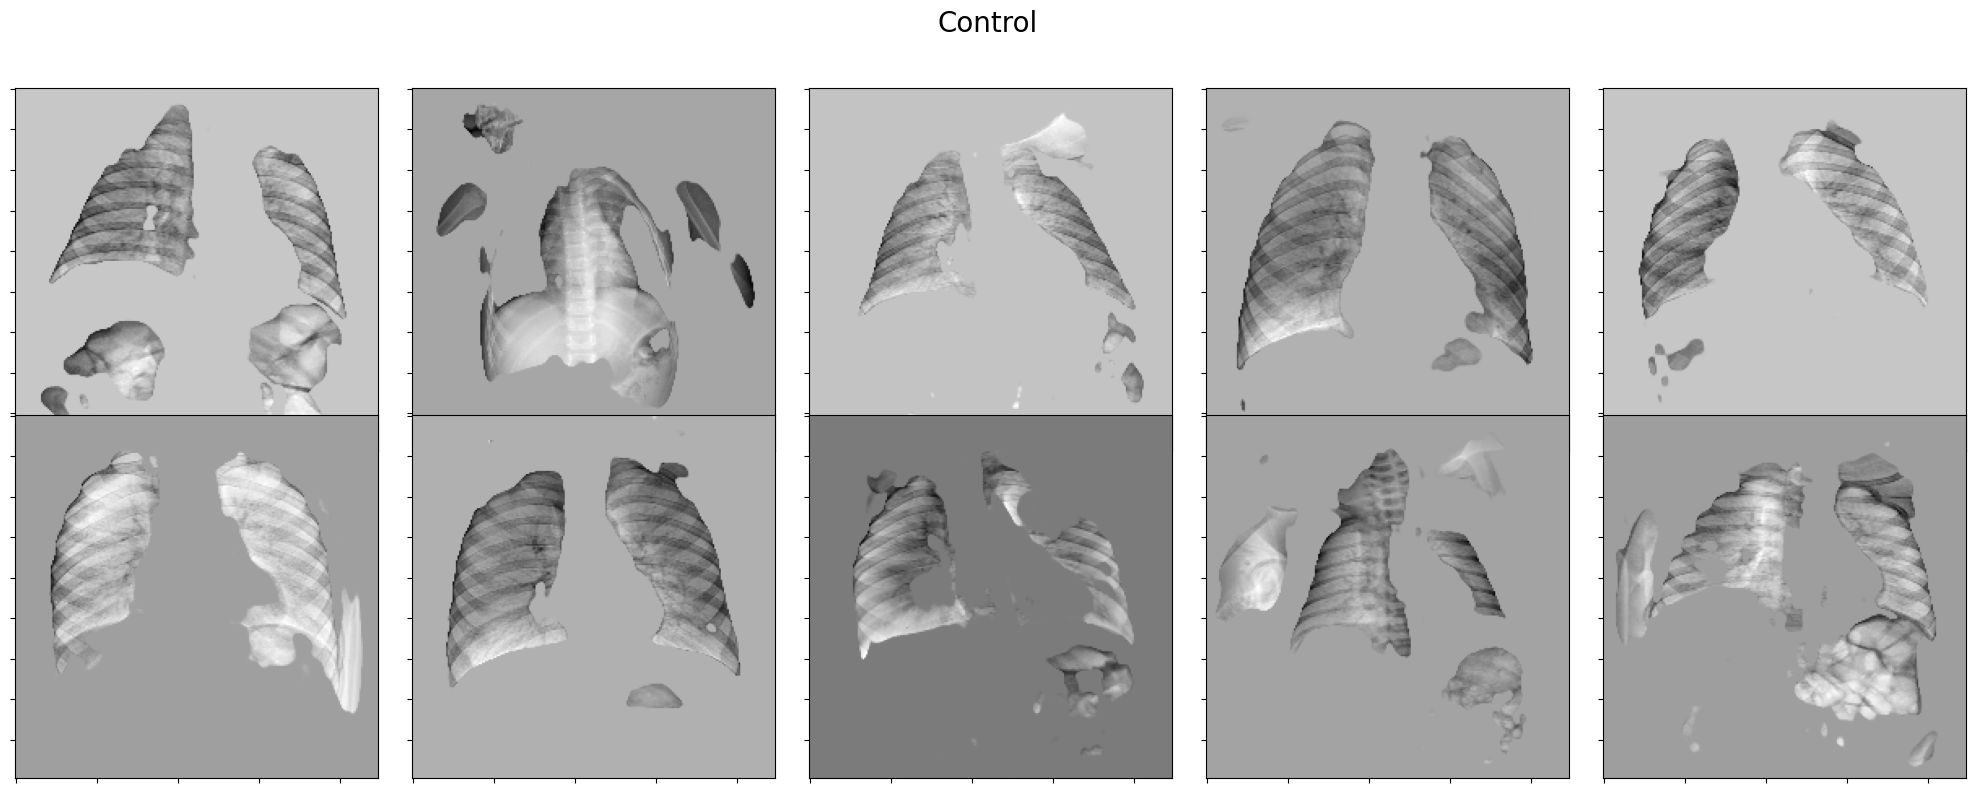

In [36]:
f = plt.figure(figsize=(20,8))
f.subplots_adjust(top=1)
num_images = Control.shape[0]
for i in range(10):
    sp = f.add_subplot(2,5,i+1)
    X2 = Control.reshape(num_images, size, size)
    X2 = img_to_array(X2[i])
    #X2 = 255-X2
    X2 = array_to_img(X2)
    plt.tick_params(labelbottom=False,
                labelleft=False,
                labelright=False,
                labeltop=False)
    plt.imshow(X2)
    plt.gray()
plt.tight_layout(rect=[0,0,1,0.9])
plt.suptitle('Control',fontsize=20)
plt.show()

# Preparation

In [37]:
#x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, random_state=42)
# X_train = x_train.reshape(-1,size, size)
# X_test = x_test.reshape(-1,size, size)

# Calculate the expected number of features based on the image size.
num_features = size * size

# Reshape the training data.
X_train = x_train[:, :num_features].reshape(-1, size, size)

# Reshape the testing data.
X_test = x_test[:, :num_features].reshape(-1, size, size)

X_train = np.repeat(X_train[..., np.newaxis], 3, -1)
X_test = np.repeat(X_test[..., np.newaxis], 3, -1)

Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

X_train.shape

(5840, 224, 224, 3)

# Efficientnet

In [38]:
import os
import random

os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_DETERMINISTIC_OPS'] = '1'

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [53]:
from tensorflow.keras.regularizers import l2


In [92]:
input_shape = X_train.shape[1:]
base_input_shape = (224, 224, 3)
num_classes = Y_train.shape[1]
x = inputs = tf.keras.layers.Input(shape=input_shape)

x = tf.keras.layers.Lambda(lambda image: tf.image.resize(image, base_input_shape[0:2]), output_shape=base_input_shape)(x)

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False, input_shape=base_input_shape, weights="imagenet")
#base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(include_top=False, input_shape=base_input_shape, weights="imagenet")
#base_model.trainable = False
#x = base_model(x, training=False)

for layer in base_model.layers[:100]:
    layer.trainable = False



# base_model.trainable = True
# x = base_model(x, training=True)

x = base_model(x, training=False)

x = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=l2(0.01))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(num_classes, kernel_regularizer=l2(0.01))(x)
outputs = tf.keras.layers.Activation('softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["accuracy"]
)

In [93]:
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_11 (Lambda)                   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 5, 5, 32)            │         368,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_11          │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2)                   │              66 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,288,178 (23.99 MB)

 Trainable params: 5,524,450 (21.07 MB)

 Non-trainable params: 763,728 (2.91 MB)

In [94]:
model_chkpt = ModelCheckpoint('best_mod.keras', save_best_only=True, monitor='val_loss')
early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights=False, patience=10)

In [95]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# datagen.fit(X_train)

In [96]:
# history = model.fit(
#     datagen.flow(X_train, Y_train, batch_size=32),
#     epochs=100,
#     validation_data=(X_test, Y_test),
#     callbacks=[model_chkpt, early_stopping]
# )


In [97]:
history = model.fit(X_train, Y_train,
          validation_split=0.20,
          epochs=50, batch_size=32, shuffle=True,
          callbacks=[model_chkpt ,early_stopping]
         )

Epoch 1/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 70s 110ms/step - accuracy: 0.5085 - loss: 1.7837 - val_accuracy: 0.4469 - val_loss: 1.3703
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5450 - loss: 1.4971 - val_accuracy: 0.7098 - val_loss: 1.1883
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.5771 - loss: 1.3925 - val_accuracy: 0.7106 - val_loss: 1.1856
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.6146 - loss: 1.3132 - val_accuracy: 0.7209 - val_loss: 1.1057
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.6481 - loss: 1.2479 - val_accuracy: 0.7166 - val_loss: 1.0550
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.6564 - loss: 1.1822 - val_accuracy: 0.7200 - val_loss: 1.0143
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.6620 - loss: 1.1251 - val_accuracy: 0.7200 - val_loss: 0.9774
Epoch 8/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.6637 - loss: 1.0847 - val_ac

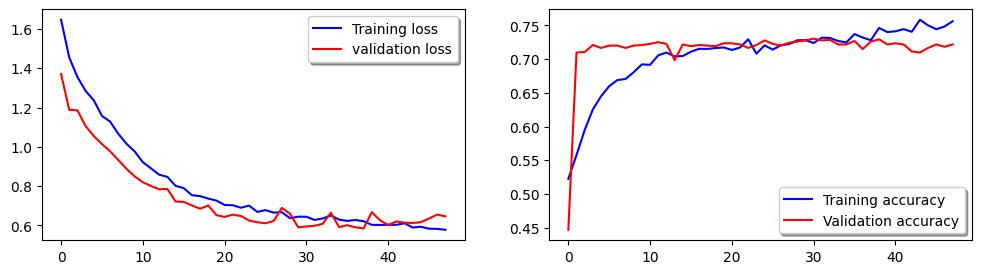

In [101]:
fig, ax = plt.subplots(1,2, figsize=(12, 3))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b',
           label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

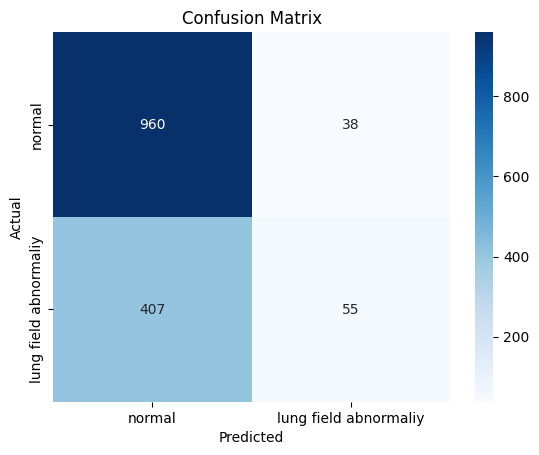

In [99]:
#model.load_weights('/content/best_mod.keras')

plt.figure()

ax = plt.subplot()

ax.set_title('Confusion Matrix')
#pred = model.predict_classes(X_test)
pred_probs = model.predict(X_test)
pred = np.argmax(pred_probs, axis=1)

Y_TEST = np.argmax(Y_test, axis =1)
cm = metrics.confusion_matrix(Y_TEST,pred)
classes=['normal', 'lung field abnormaliy']
sns.heatmap(cm, annot=True,xticklabels=classes, yticklabels=classes,cmap='Blues',fmt=".0f")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show

In [102]:
print(classification_report(Y_TEST, pred))
print('normal = 0 , case = 1')

              precision    recall  f1-score   support

           0       0.70      0.96      0.81       998
           1       0.59      0.12      0.20       462

    accuracy                           0.70      1460
   macro avg       0.65      0.54      0.51      1460
weighted avg       0.67      0.70      0.62      1460

normal = 0 , case = 1
